In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm
import os

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "medium_mlr_hier"
n = 10000
signal_to_noise = 4

L = 5

ranks = np.array([10, 4, 3, 2, 1])
rank = ranks.sum()

In [4]:
nsamples = 4 * rank
nsamples

80

In [5]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=10000.0
level=1, num_groups=4, mean_size=2500.0
level=2, num_groups=8, mean_size=1250.0
level=3, num_groups=16, mean_size=625.0
level=4, num_groups=10000, mean_size=1.0


In [6]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [7]:
folder_path = "slurm/outputs"
pickle_files = [f for f in os.listdir(folder_path) if f.endswith('.pickle')]

ll_distribution = {"frob":{"train":[], "exp":[]},
                   "mle":{"train":[], "exp":[]}}

for file in pickle_files:
    file_path = os.path.join(folder_path, file)
    if not "n10000" in file_path: continue
    with open(file_path, 'rb') as f:
        ll_i = pickle.load(f)

    print(- np.mean(ll_i["frob"]["exp"]) + np.mean(ll_i["mle"]["exp"]))
    ll_distribution["frob"]["train"] += ll_i["frob"]["train"]
    ll_distribution["frob"]["exp"] += ll_i["frob"]["exp"]
    ll_distribution["mle"]["train"] += ll_i["mle"]["train"]
    ll_distribution["mle"]["exp"] += ll_i["mle"]["exp"]

288.07153625824867
243.20276500482942
301.99369651211236
296.4500030614254
274.21184939705563
357.7770116800275
304.66494955496455
264.9675459387181


200 samples in histogram


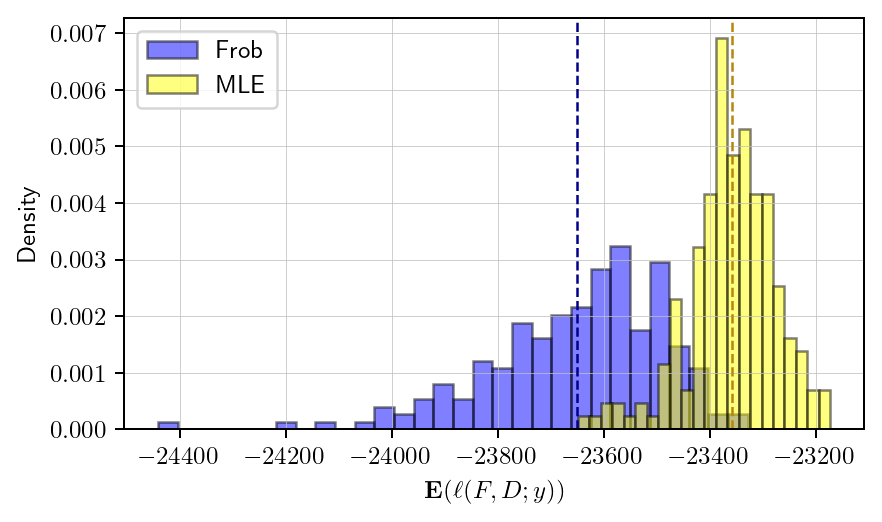

In [8]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

mean1, std1 = np.mean(ll_distribution["frob"]["exp"]), np.std(ll_distribution["frob"]["exp"])
mean2, std2 = np.mean(ll_distribution["mle"]["exp"]), np.std(ll_distribution["mle"]["exp"])

print(len(ll_distribution["frob"]["exp"]), "samples in histogram")

plt.hist(ll_distribution["frob"]["exp"], bins=30, alpha=0.5, color='blue', label='Frob', density=True, edgecolor='black')
plt.hist(ll_distribution["mle"]["exp"], bins=22, alpha=0.5, color='yellow', label='MLE', density=True, edgecolor='black')

plt.axvline(mean1, color='darkblue', linestyle='--', linewidth=1)
plt.axvline(mean2, color='darkgoldenrod', linestyle='--', linewidth=1)

# plt.title('Distribution of expected log-likelihoods')
plt.xlabel(r'$\mathbf{E} (\ell(F, D; y))$')
plt.ylabel('Density')
plt.legend()
plt.grid(color='silver', linestyle='-', linewidth=0.3)  # Adjust the color, linestyle, and linewidth
axs.grid(True)
plt.tight_layout()
plt.savefig(f"plots/hist_{filename}.pdf", bbox_inches='tight')

200 samples in histogram


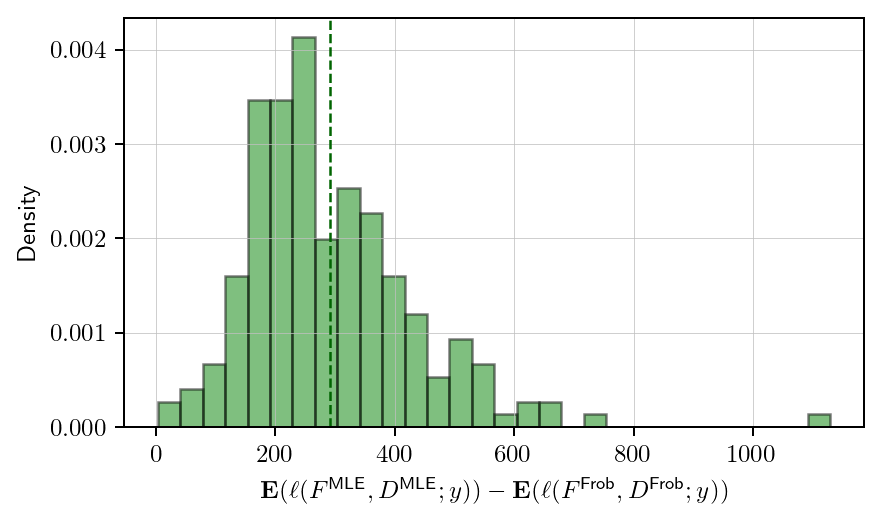

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

diff = np.array(ll_distribution["mle"]["exp"]) - np.array(ll_distribution["frob"]["exp"])
mean = np.mean(diff)

print(len(ll_distribution["frob"]["exp"]), "samples in histogram")
plt.hist(diff, bins=30, alpha=0.5, color='green', label='MLE', density=True, edgecolor='black')

plt.axvline(mean, color='darkgreen', linestyle='--', linewidth=1)

# plt.title('Distribution of expected log-likelihoods')
plt.xlabel(r'$\mathbf{E} (\ell(F^{\text{MLE}}, D^{\text{MLE}}; y))- \mathbf{E} (\ell(F^{\text{Frob}}, D^{\text{Frob}}; y))$')
plt.ylabel('Density')
# plt.legend()
plt.grid(color='silver', linestyle='-', linewidth=0.3)  
axs.grid(True)
plt.tight_layout()
plt.savefig(f"plots/hist_diff_{filename}.pdf", bbox_inches='tight')

In [10]:
diff[diff<0].size / diff.size * 100

0.0

In [11]:
np.mean(diff), np.std(diff)

(291.41741967592213, 142.6556242995222)

# True model loglikelihoods

In [12]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)
row_selectors, si_groups, F_hpart = mfm.row_col_selections(hpart)
permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}

signal_var=18.984962575662617, noise_var=4.664840773574106
SNR=4.069798627042253, signal_to_noise=4
num_levels=5, num_sparsities=16
(16, 4) [ 0  3  7 15]


In [13]:
C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
del C
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]
# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

In [14]:
true_F, true_D = true_mlr.B[:, :-1]+0, true_D_noise+0
true_mfm = mfm.MFModel(F=true_F, D=true_D, hpart=F_hpart, ranks=ranks)

true_train_obj = mfm.fast_loglikelihood_value(true_F, true_D, Y, ranks, permuted_F_hpart,
                                           tol1=1e-5, tol2=1e-5)
exp_true_ll = mfm.fast_exp_true_loglikelihood_value(true_F, true_D, ranks, F_hpart,
                                           tol1=1e-5, tol2=1e-5)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_ll}")

TR: train ll=-20532.912308428182, exp ll=-20574.88218165958


In [15]:
true_mfm.num_factors()

82

# Distribution of $\mathbf{E}_y\ell(\theta(Y^{\text{train}}); y)$

In [16]:

# with open(f"outputs/hist_ll_{filename}.pickle", 'rb') as file:
#     ll_distribution = pickle.load(file)

In [17]:
for t in range(1):
    print(f"{t=}")
    C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
    Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
    del C
    unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]
    # permute to put clusters on diagonal
    Y = Z.T
    N = Y.shape[0]

    # Frobenius 
    frob_mfm, losses = mfm.fast_frob_fit_loglikehood(unpermuted_A, Y, F_hpart, hpart, ranks, printing=False, eps_ff=1e-3)
    frob_mfm.D = np.maximum(1e-6, frob_mfm.D )
    obj_frob = mfm.fast_loglikelihood_value(frob_mfm.F, frob_mfm.D, Y, ranks, permuted_F_hpart)
    frob_mfm.inv_coefficients()
    obj_frob_exp = mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                            frob_mfm, ranks, hpart["rows"], F_hpart, 
                                                            row_selectors, si_groups, tol1=1e-8, tol2=1e-8)
    
    print(f"FR: train ll={obj_frob}, exp ll={obj_frob_exp}")

    # MLE
    fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=False, max_iter=300, freq=100)
    fitted_mfm.inv_coefficients()
    obj_exp = mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                            fitted_mfm, ranks, hpart["rows"], F_hpart, 
                                                            row_selectors, si_groups, tol1=1e-8, tol2=1e-8)

    print(f"ML: train ll={loglikelihoods[-1]}, exp ll={obj_exp}")

t=0


/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


FR: train ll=-19290.912312809818, exp ll=-23256.863963390322
ML: train ll=-19151.155234116715, exp ll=-23159.08073332553


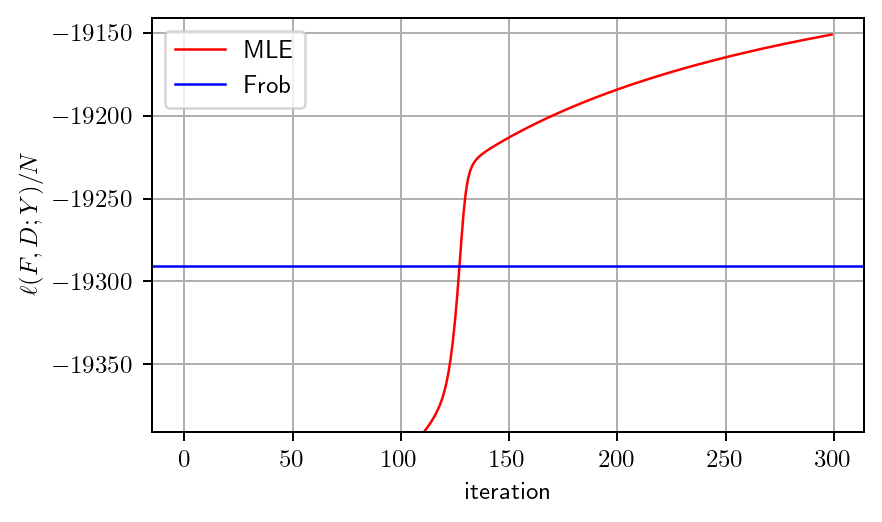

In [24]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

ll = np.array(loglikelihoods[1:])
# print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]["train"]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)]["train"])/obj_frobs[str(ranks)]["train"]*100:.2f}")
axs.plot(ll, color='r', lw=1, label=r"$\text{MLE}$")
axs.set_xlabel('iteration')
axs.axhline(obj_frob, 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
# axs.set_yscale('symlog')
axs.set_ylim([obj_frob - 100, ll.max() + 10])
# axs.axhline(y=true_test_obj, label='True', c='g', alpha=0.5)
axs.grid(True)
axs.legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

In [19]:
print(f"FR: train ll={obj_frob}, exp ll={obj_frob_exp}")
print(f"ML: train ll={loglikelihoods[-1]}, exp ll={obj_exp}")
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_ll}")

FR: train ll=-19290.912312809818, exp ll=-23256.863963390322
ML: train ll=-19151.155234116715, exp ll=-23159.08073332553
TR: train ll=-20532.912308428182, exp ll=-20574.88218165958


In [20]:
obj_exp - obj_frob_exp

97.78323006479332

In [27]:
np.round(obj_frob)

-19291.0

In [26]:
-19151+19291, -23159+23257

(140, 98)

In [22]:
- np.mean(ll_distribution["frob"]["exp"]) + np.mean(ll_distribution["mle"]["exp"])

291.41741967592316